# NLP for Sentiment Analysis with Twitter Data

## Introduction

The goal of this project is to build a model that can classify the sentiment of a tweet based on its contents. 

The data used is sourced from Twitter from SXSW 2013, and contains tweets about the SXSW tech events and product announcements. Most of the tweets are about Apple and Google products, so I will analyze sentiment for each brand. The raw data can be found in the data folder in this repository.

The data was manually labeled for classification, and contains the tweet text, the product or brand mentioned, and the sentiment as interpreted by the labeler.


## Business Objective

The resulting model will be used to classify tweets from future tech conferences from Google and Apple, and analyze how sentiment for the brands has changed over time. 

## Data Exploration and Cleaning

After running all the relevant imports and the csv file, I can preview the dataset below.There are three columns, where the column describing the brand/product is mostly null. There is only one null in the tweet text column so I will drop that. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.naive_bayes import ComplementNB
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# theres's only one null in the tweet text column so I'm dropping it here
raw_data = raw_data.drop(index=6, axis=0)
raw_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Taking a look at the subjects of the tweets, I can see they are labeled with several subcategories of Google and Apple products. However, most of this column is null values.  

In [4]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
raw_data['emotion_in_tweet_is_directed_at'].isna().sum()

5801

And looking at the sentiment, it looks like most of these are labeled as neutral and there are actually very few negative tweets. I assume this is because the tweets are from product announcements at SXSW, so the atmosphere is focused on excitement or news around new product launches. 

In [6]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I want to take a closer look at the 'I can't tell' category to see if I can group it in with neutral or if I should disregard. 

In [7]:
ct_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'I can\'t tell']
ct_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


Some tweets look actually neutral, and some like the one I've selected below maybe are sarcastic but even I am not sure if I would actually categorize this as negative. It seems unrealistic to go through all of these and it also doesn't make sense to have an 'I don't know' class so I'm going to relabel them as neutral along with the 'no emotion' tweets.

In [8]:
ct_df.loc[237][0]

'Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw'

I also want to preview the neutral tweets... and they look pretty neutral. So I'm going to create a new classifier column to sort these into: -1 for negative and 1 for positive. The neutrals will be the default 0.

In [9]:
ne_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
ne_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [10]:
#creating a new column for multiclass problem
raw_data['class'] = 0
for row in raw_data.index:
    if raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Positive emotion':
        raw_data['class'][row] = 1
    elif raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Negative emotion':
        raw_data['class'][row] = -1
        
raw_data.head(10)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,1
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,1
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,1
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1


The classes are pretty imbalanced. This could become a problem when working through the modeling so I will keep this in mind. 

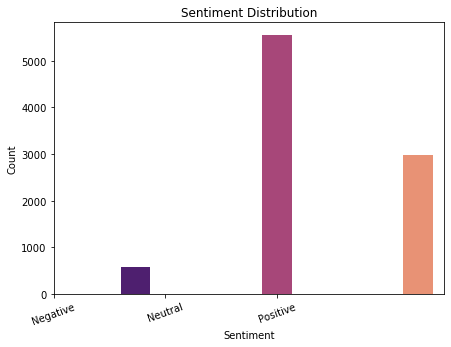

In [11]:
plt.figure (figsize=(7,5))
ax = sns.countplot(x = 'class', hue = 'class', data = raw_data, palette = 'magma')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([-1, 1, 0], ['Negative', 'Positive', 'Neutral'], rotation=20)
ax.get_legend().remove()

plt.show()

#update this to add products or change chart?

Another problem is that the data is missing a lot of labels for the product/brand. When I look at the nulls, I can actually see a lot of the product mentions in them so I'm going to see if I can label a few more.

In [12]:
nulls_df = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]

print('There are', len(nulls_df), 'unlabeled tweets out of', len(raw_data),
      'total which equates to', round(len(nulls_df)/len(raw_data)*100,2), "%")

There are 5801 unlabeled tweets out of 9092 total which equates to 63.8 %


In [13]:
nulls_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,0
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,0
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,0
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,0


Most of the unlabeled tweets are neutral anyway so they really don't have a lot of info. 

In [14]:
nulls_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5297
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

However, from the above preview I can clearly see brand/product mentions so I'm going to go through this and search for both Apple and Google related terms.

In [15]:
apple_searchwords = ['iPad','iTunes','Apple', 'apple', 'iPhone', 'macbook']

apple = nulls_df[nulls_df['tweet_text'].str.findall('^(?:'+'|'.join(apple_searchwords) + ')').apply(len) > 0].fillna('Apple')

apple.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
78,iPad2? RT @mention Droid &amp; Mac here :) RT ...,Apple,No emotion toward brand or product,0
194,Apple has 200M users' credit cards sync'd with...,Apple,No emotion toward brand or product,0
222,Apple has a temporary Retail Store in Austin f...,Apple,No emotion toward brand or product,0
230,Apple IIe ad in the '85 SI swimsuit issue at a...,Apple,No emotion toward brand or product,0
254,iPad 2 vs Android vs The World : Panel at #SXS...,Apple,No emotion toward brand or product,0


Of course, this doesn't work perfectly as with the below example but it's an efficient method. 

In [16]:
nulls_df.loc[65][0]

'Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw'

In [17]:
google_searchwords = ['android','Google','android']

google = nulls_df[nulls_df['tweet_text'].str.findall('^(?:'+'|'.join(google_searchwords) + ')').apply(len) > 0].fillna("Google")
google.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
256,Google is announcing a social network &quot;Ci...,Google,No emotion toward brand or product,0
397,Google to Circle Austin? #sxsw {link},Google,No emotion toward brand or product,0
422,Google to debut new selective social network t...,Google,No emotion toward brand or product,0
542,Google to give social networking another try w...,Google,No emotion toward brand or product,0
623,Google to Host Developer Day at SXSW {link} #s...,Google,No emotion toward brand or product,0


In [18]:
apple_indexes = list(apple.index)
google_indexes = list(google.index)

In [19]:
# if raw_data.index is in apple_indexes:
#     raw_data['emotion_in_tweet_is_directed_at'].fillna('Apple')

These mostly look correct though and I've added 430 new labels to the data. 

In [20]:
# binary indicator
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'iPad' or 'Apple' or'iPad or iPhone App' or 'iPhone' or 'Other Apple product or service':
#         raw_data['apple'] = 1
        
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'Google' or 'Android App' or'Android' or 'Other Google product or service':
#         raw_data['google'] = 1    

In [26]:
grouped_negative = raw_data[raw_data['class'] == -1 ].groupby('emotion_in_tweet_is_directed_at').count()
grouped_negative = grouped_negative.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

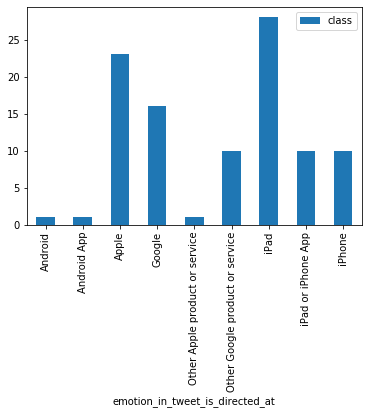

In [22]:
grouped_negative.plot(kind='bar', stacked=True)

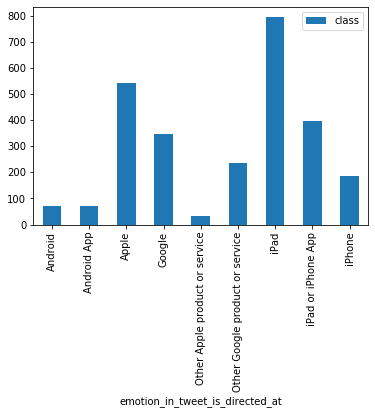

In [23]:
grouped_positive = raw_data[raw_data['class'] == 1].groupby('emotion_in_tweet_is_directed_at').count()
grouped_positive = grouped_positive.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])
grouped_positive.plot(kind='bar', stacked=True)

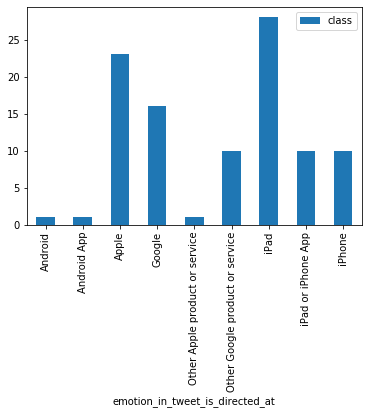

In [28]:
grouped_neutral = raw_data[raw_data['class'] == 0].groupby('emotion_in_tweet_is_directed_at').count()
grouped_neutral = grouped_neutral.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])
grouped_neutral.plot(kind='bar', stacked=True)

In [29]:
raw_data['class'].value_counts(normalize=True)

 0    0.609767
 1    0.327541
-1    0.062692
Name: class, dtype: float64

## Preprocessing

I'm going to start a new column for processed text. The first step I am going to take is to remove handles, since they aren't actual content and shouldn't convey tone. 

I'm using regex to grab these as well as URLs replace them with nothing. The example below shows they have been removed!

In [30]:
raw_data['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in raw_data['tweet_text']]

In [31]:
print(raw_data.iloc[14][0])
print(raw_data.iloc[14][4])

haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw
haha, awesomely rad iPad app by   #hollergram #sxsw


Now, I can compile a list of stopwords from NLTK so I can remove all the filler words in the text that don't actually contain any information. This will also remove punctuation for when the tweets are tokenized. 

In [32]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

Before I move into modeling, I am going to take a look at what my data will contain when tokenized:

In [33]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [token.lower() for token in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

processed_data = list(map(process_tweet, raw_data['clean_tweet']))
processed_data[5]

['new',
 'ipad',
 'apps',
 'speechtherapy',
 'communication',
 'showcased',
 'sxsw',
 'conference',
 'iear',
 'edchat',
 'asd']

In this set with stop words removed there are 10,560 unique words,and some of the most frequent are general twitter words - 'rt', 'link'. Many however are referring to products and events. The word cloud helps demonstrate the scope of the subjects of these tweets.

In [34]:
total_vocab = set()
for token in processed_data:
    total_vocab.update(token)
    
print(len(total_vocab))

10559


In [35]:
tweet_concat = []
for tweet in processed_data:
    tweet_concat += tweet
    
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(2000)

[('sxsw', 9511),
 ('link', 4313),
 ('rt', 2960),
 ('google', 2594),
 ('ipad', 2445),
 ('apple', 2304),
 ('quot', 1696),
 ('iphone', 1529),
 ('store', 1477),
 ("'s", 1237),
 ('2', 1122),
 ('new', 1087),
 ('austin', 964),
 ('amp', 836),
 ('app', 817),
 ('launch', 653),
 ('circles', 651),
 ('social', 648),
 ('today', 580),
 ('android', 577),
 ("n't", 481),
 ('network', 465),
 ('ipad2', 459),
 ('pop-up', 420),
 ('via', 413),
 ('line', 402),
 ('free', 387),
 ('get', 386),
 ('called', 361),
 ('party', 349),
 ('sxswi', 340),
 ('mobile', 338),
 ('one', 312),
 ('major', 301),
 ('like', 291),
 ('time', 274),
 ("'re", 265),
 ('temporary', 264),
 ('opening', 257),
 ("'m", 254),
 ('possibly', 240),
 ('people', 228),
 ('apps', 225),
 ('downtown', 225),
 ('great', 222),
 ('see', 220),
 ('maps', 219),
 ('going', 218),
 ('day', 218),
 ('check', 217),
 ('mayer', 214),
 ('open', 210),
 ('popup', 209),
 ('go', 207),
 ('need', 205),
 ('marissa', 189),
 ('know', 185),
 ('got', 185),
 ('w/', 182),
 ('come', 

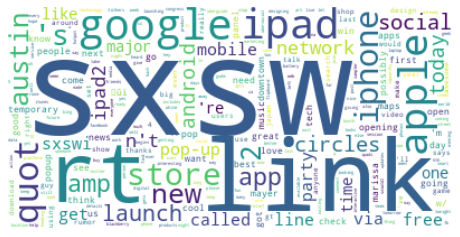

In [36]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()

In [37]:
#lemmatization

# import spaCy's language model 
# nlp = spacy.load('en', disable=['parser', 'ner'])

# # function to lemmatize text
# def lemmatization(texts):
#     output = []
#     for i in texts:
#         s = [token.lemma_ for token in nlp(i)]
#         output.append(' '.join(s))
#     return output

## Modeling with Classifiers

Now that I have a thorough understanding of the data, I'm going to test out different classifiers to see how effective they are. I'll start with Multinomial Naive Bayes as my baseline model, as this is commonly used for NLP.

### Baseline Model: Multinomial Naive Bayes with Count Vectorizer

I'll also use a count vectorizer with this baseline model since it's one of the more simple techniques. This will pull in the stop words list that I defined above and fit to train and test variables. 

In [38]:
X = raw_data['clean_tweet']
y = raw_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

#define holdout set

In [39]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

Now I'll instantiate the classifier and fit it to the vectorized variables. I am defining a function to easily return the score of the classifier as well as a confusion matrix so I can compare performance of different models. 

In [40]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_count, y_train)

MultinomialNB()

In [41]:
def score(clf, X_train, y_train, X_test, y_test):
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    train_score = accuracy_score(y_train, train_preds)
    test_score = accuracy_score(y_test, test_preds)
    print('test accuracy score =', test_score, 
          'train accuracy score =', train_score)
    plot_confusion_matrix(clf, X_test, y_test)

test accuracy score = 0.691597008358997 train accuracy score = 0.825780906291245


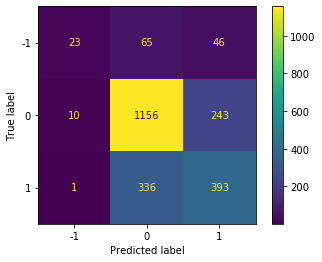

In [42]:
score(nb_classifier, X_train_count, y_train, X_test_count, y_test)

My first model is quite overfit, and it may be having trouble learning because the classes are so imbalanced. The next thing I'm going to try is changing to a TF-IDF vectorizer, which penalizes words that show up more frequently. This could help the model value words like sxsw, google, and apple less, and instead actually look for words that indicate sentiment.

### MNB with TF-IDF

As a starting point, I'm setting the TF-IDF vectorizer to ignore terms that appear in more than 90% of the tweets. Now I can see that more unique words, like 'giveaway' are rising to the top.

In [43]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .90, 
                        use_idf=True)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [44]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [45]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[5]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

giveaway    0.532406
blog        0.532406
post        0.491634
ipad2       0.325260
new         0.254513
link        0.144263
Name: 5, dtype: float64


In [46]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(tfidf_train, y_train)

MultinomialNB()

test accuracy score = 0.6709194896612406 train accuracy score = 0.7537762135210442


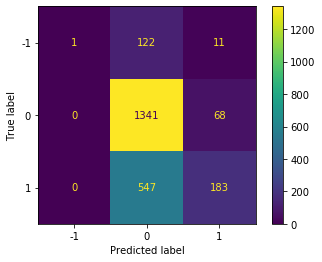

In [47]:
score(nb_tfidf, tfidf_train, y_train, tfidf_test, y_test)

This model is less overfit, but it's still not good. It only correctly predicted one negative. The test score actually went down as well, so I'm going to try another type of classifier.

### Complement Naive Bayes

Complement Naive Bayes is similar to MNB, but is adapted to suit imbalanced data sets as it uses the complement of each class to compute the model’s weights. According to SciKit learn documentation, CNB regularly outperforms MNB on text classification tasks.


In [48]:
cnb = ComplementNB()
cnb.fit(tfidf_train, y_train)

ComplementNB()

test accuracy score = 0.6836779586449626 train accuracy score = 0.8279806423229212


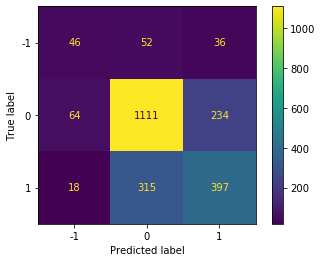

In [49]:
score(cnb, tfidf_train, y_train, tfidf_test, y_test)

CNB barely increased the test score, but made the model even more overfit! I'm going to try something different.

### Support Vector Machines

SVMs are said to help reduce overfitting, and SVC has a regularization parameter C which can be tuned. There are also different kernel types that can be applied. Since I'm not sure where to start, I'm going to use a grid search to try different options. 

In [50]:
from sklearn.svm import SVC

svc_param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'], #trying all the options
    'C': [10000, 100, 1, 0.1], #the C value is inversely proportional to the strength of regularization
}

svc_clf = SVC()

svc_grid_search = GridSearchCV(svc_clf, svc_param_grid, scoring='accuracy')


svc_grid_search.fit(tfidf_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [10000, 100, 1, 0.1],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [51]:
svc_grid_search.best_params_

{'C': 1, 'kernel': 'linear'}

test accuracy score = 0.7061152661680599 train accuracy score = 0.838539375274967


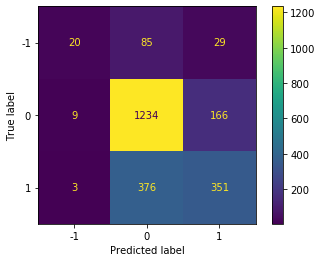

In [52]:
svc_clf = SVC(kernel= 'linear', C=1)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

This is the highest accuracy score yet, by a small amount. However, overfitting is still an issue. I can see that there is error across all classes.

## Modeling with Deep Learning

Since these classifiers aren't seeing great results, I'm going to take this a step further with pre-trained word embeddings and neural networks.

### GloVe

In [96]:
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [54]:
glove = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [55]:
glove['sxsw']

array([-0.54213  , -0.40598  , -0.57972  ,  0.68902  , -1.2828   ,
       -1.4274   , -0.3113   , -0.37996  ,  0.85759  ,  0.74349  ,
       -0.27944  , -1.2856   ,  0.30916  ,  0.10983  ,  0.76612  ,
        0.052707 , -0.045862 ,  0.97209  , -0.388    ,  0.0061045,
        0.36166  ,  0.063978 ,  0.60576  ,  1.1596   , -0.22204  ,
        0.55524  , -1.1646   , -0.11687  , -1.2104   , -0.90578  ,
        0.36391  ,  0.20946  , -0.19362  , -0.99614  , -0.18209  ,
       -0.13782  ,  0.2144   , -0.038234 , -0.29907  , -0.39556  ,
       -0.61547  ,  0.1485   , -1.0864   , -0.42129  , -0.42307  ,
        0.51809  ,  1.0751   , -0.30472  , -1.4201   ,  1.007    ],
      dtype=float32)

In [56]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [83]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(raw_data['clean_tweet']))
list_tokenized = tokenizer.texts_to_sequences(raw_data['clean_tweet'])
X_t = sequence.pad_sequences(list_tokenized)

In [84]:
X_t.shape

(9092, 32)

In [88]:
y = raw_data['class']

(9092,)

First, trying an ensemble method http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

etree_w2v = Pipeline([
    ("word2vec vectorizer", W2vVectorizer(glove)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [59]:
etree_w2v.fit(X_train, y_train)

Pipeline(steps=[('word2vec vectorizer',
                 <__main__.W2vVectorizer object at 0x0000021DF7EC1A20>),
                ('extra trees', ExtraTreesClassifier(n_estimators=200))])

test accuracy score = 0.6489221293444787 train accuracy score = 0.9608446986361636


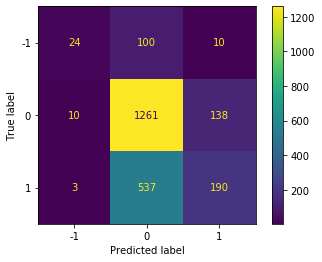

In [60]:
score(etree_w2v, X_train, y_train, X_test, y_test)

Then building a neural net

In [61]:
model = Sequential()

In [62]:
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))

In [63]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                2

In [89]:
model.fit(X_t, y, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3


ValueError: in user code:

    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 41) are incompatible


https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb

### Word2Vec

In [107]:
data = raw_data['clean_tweet'].map(word_tokenize)

In [114]:
data[:5]

0    [., I, have, a, 3G, iPhone, ., After, 3, hrs, ...
1    [Know, about, ?, Awesome, iPad/iPhone, app, th...
2    [Can, not, wait, for, #, iPad, 2, also, ., The...
3    [I, hope, this, year, 's, festival, is, n't, a...
4    [great, stuff, on, Fri, #, SXSW, :, Marissa, M...
Name: clean_tweet, dtype: object

In [115]:
processed_data[:5]

[['3g',
  'iphone',
  '3',
  'hrs',
  'tweeting',
  'rise_austin',
  'dead',
  'need',
  'upgrade',
  'plugin',
  'stations',
  'sxsw'],
 ['know',
  'awesome',
  'ipad/iphone',
  'app',
  "'ll",
  'likely',
  'appreciate',
  'design',
  'also',
  "'re",
  'giving',
  'free',
  'ts',
  'sxsw'],
 ['wait', 'ipad', '2', 'also', 'sale', 'sxsw'],
 ['hope',
  'year',
  "'s",
  'festival',
  "n't",
  'crashy',
  'year',
  "'s",
  'iphone',
  'app',
  'sxsw'],
 ['great',
  'stuff',
  'fri',
  'sxsw',
  'marissa',
  'mayer',
  'google',
  'tim',
  "o'reilly",
  'tech',
  'books/conferences',
  'amp',
  'matt',
  'mullenweg',
  'wordpress']]

In [116]:
model = Word2Vec(data, window=5, min_count=1, workers=4)

In [117]:
model.train(data, total_examples=model.corpus_count, epochs=10)

(1377021, 2073890)

In [118]:
wv = model.wv

In [119]:
wv['apple']

array([ 0.8506056 , -0.37071833,  0.03321022, -0.47568592,  1.1385642 ,
       -1.3936449 ,  0.3740237 , -0.37940863,  0.64656985, -3.068479  ,
        2.3867702 , -2.481776  ,  1.0774105 ,  0.82457626, -0.8092293 ,
       -0.69056433,  0.8034972 ,  0.41849014, -0.87668556,  0.34413487,
        2.3748388 ,  0.32377148,  0.08655268,  0.3316786 , -0.10216703,
        0.10459099,  2.1783085 ,  1.3011229 , -1.4811122 ,  1.1897577 ,
        0.56156766, -2.868104  ,  1.2720194 , -2.5759933 , -2.2725825 ,
       -0.4426617 ,  0.75164413,  1.5867082 ,  0.1921221 ,  0.97124296,
       -0.03729137, -1.9981672 ,  1.0282654 ,  1.7208487 , -0.19747001,
       -1.2043891 , -0.10876191, -3.4321907 ,  1.5194607 ,  1.2259089 ,
        2.9491534 , -1.5228779 , -2.728404  , -1.1918999 , -1.331018  ,
        0.29509583,  2.3408282 ,  0.66817963, -2.8225632 , -0.08963297,
       -1.0926403 ,  0.871     , -0.45376578,  1.3484511 ,  0.02109395,
        1.6708224 , -0.10179199,  0.3506653 , -1.9758109 , -0.11

In [120]:
wv.most_similar('apple')


[('pop-up', 0.782987117767334),
 ('Apple', 0.7716089487075806),
 ('whattechnerdsdodrunk', 0.7614254951477051),
 ('popup', 0.7570643424987793),
 ('ipad2', 0.7285839319229126),
 ('temp', 0.7175039649009705),
 ('pop', 0.7164602279663086),
 ('AppleATXdt', 0.7150189876556396),
 ('appropriately', 0.7097368836402893),
 ('stocked', 0.707023561000824)]

use elmo: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

In [94]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

RuntimeError: Exporting/importing meta graphs is not supported when eager execution is enabled. No graph exists when eager execution is enabled.